In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
sns.set(style="white")
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
os.getcwd()

'/home/andrzej/Documents/Studia/inzynierka/StockPricePrediction/src/visualization'

In [16]:
with open('../../data/interim/features.pickle', 'rb') as file:
    features = pickle.load(file)
date = features['Date']
features.drop('Date', inplace=True, axis=1)

# calculate difference between rows
features_diff = features.pct_change().replace([np.inf, -np.inf], np.nan)

# impute NaN values
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(features_diff)
features_diff = imp_mean.transform(features_diff)

# features_diff.dropna()
features_diff = pd.DataFrame(data=features_diff, columns=features.columns)

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(features)
features_ = imp_mean.transform(features)
features_ = pd.DataFrame(data=features_, columns=features.columns)

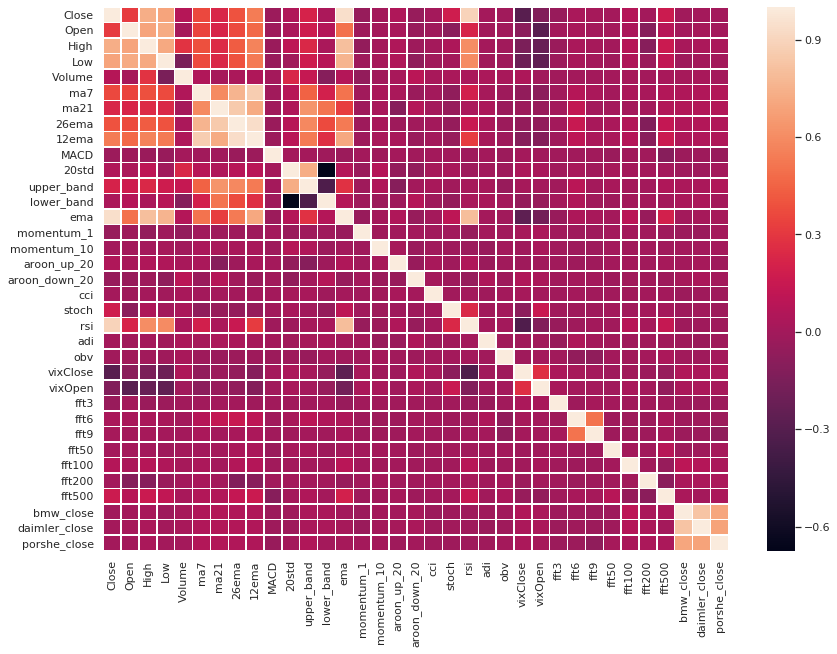

In [4]:
plt.figure(figsize = (14,10))

ax = sns.heatmap(features_diff.corr(), annot=False, linewidths=.5)

<Figure size 1008x1008 with 0 Axes>

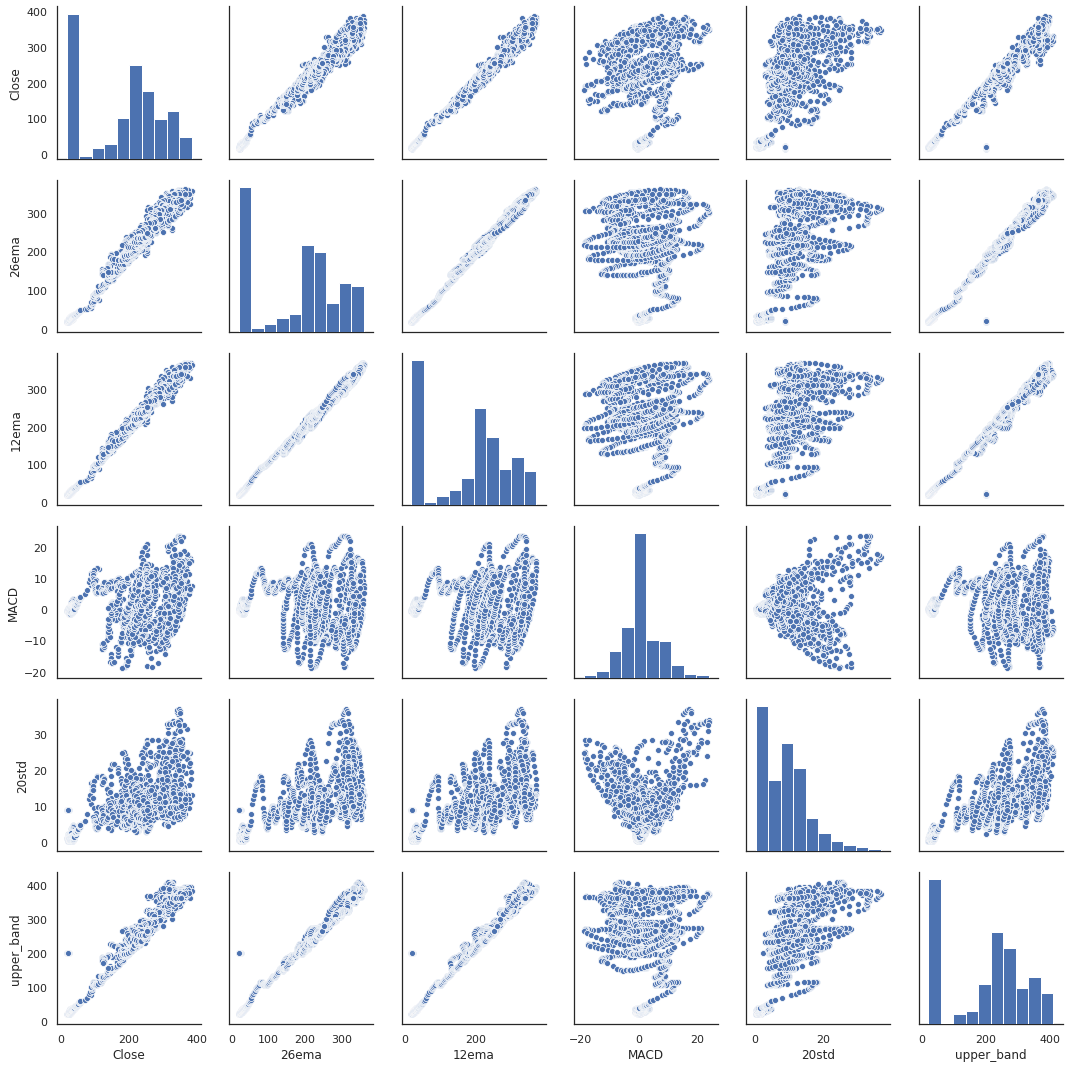

In [5]:

plt.figure(figsize = (14,14))

ax = sns.pairplot(features_.iloc[:, [0,7,8,9,10,11]])

In [11]:
features_.iloc[:, :2]
, hue='Close'

,Close,Open
0,23.89,19.00
1,23.83,25.79
2,21.96,25.00
3,19.20,23.00
4,16.11,20.00
...,...,...
2366,352.22,360.00
2367,354.83,354.51
2368,333.04,340.16
2369,336.34,344.32


In [17]:
targets_ = pd.DataFrame(features_['Close'].pct_change(), columns=['Close'])
bin_labels = (targets_['Close'] >= 0).astype(np.int32).values[1:]

bin_labels = bin_labels[700:]
features_ = features_.iloc[700:]

0.5595238095238095

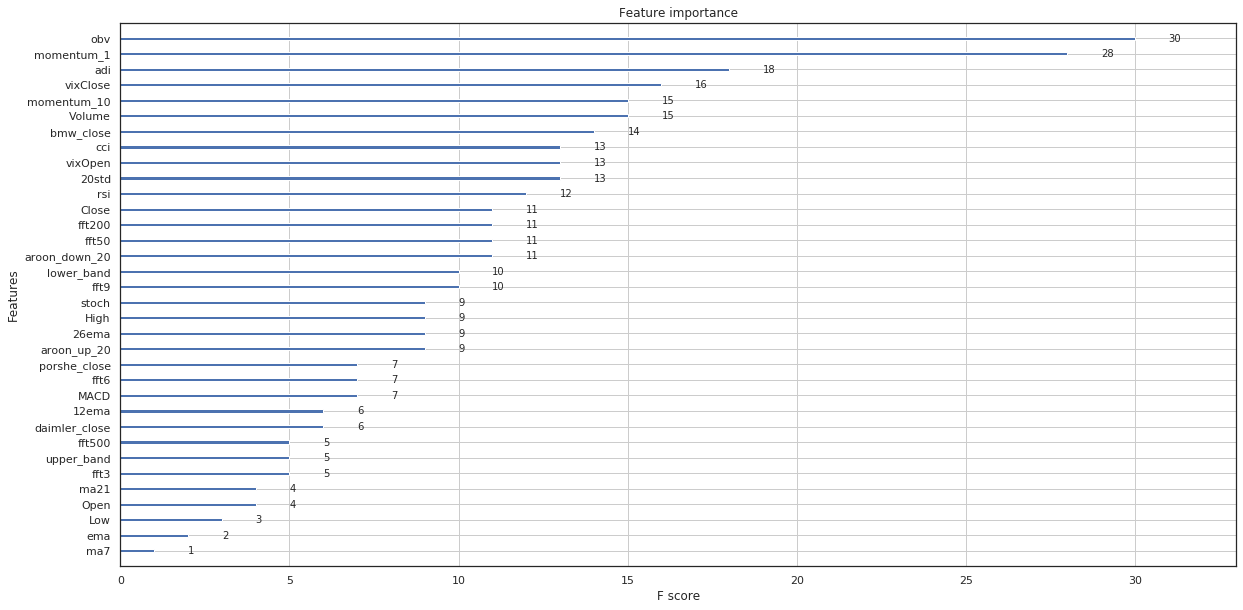

In [45]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score




x_train, x_test, y_train, y_test = train_test_split(features_.iloc[:-1], bin_labels, test_size=0.2, shuffle=False)
scl = StandardScaler()
scl.fit(x_train)
x_train = pd.DataFrame(scl.transform(x_train), columns=features_.columns.to_list())
x_test = pd.DataFrame(scl.transform(x_test), columns=features_.columns.to_list())

clf = xgb.XGBClassifier(n_estimators=5, max_depth=6, gamma=0.2)
fig, ax = plt.subplots(figsize=(20, 10))
xgb.plot_importance(model, ax=ax)
preds = model.predict(x_test)
accuracy_score(y_test, preds)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


0.5767459164511214

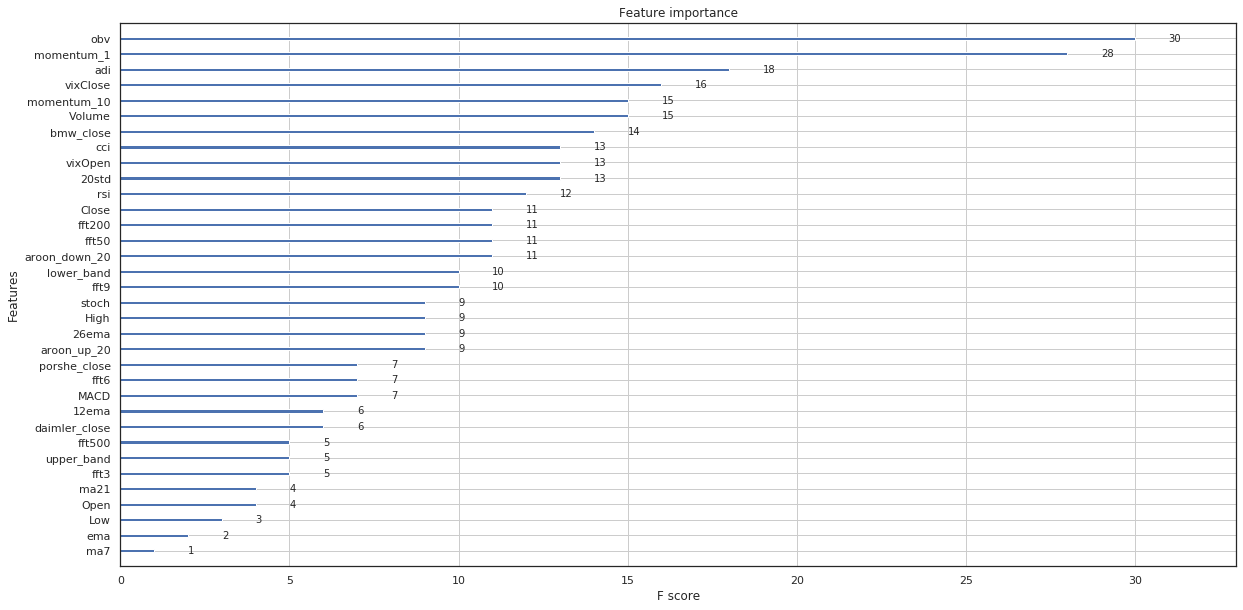

In [32]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(solver='lbfgs', max_iter=300, verbose=1)
m = logit.fit(x_train, y_train)
fig, ax = plt.subplots(figsize=(20, 10))
xgb.plot_importance(model, ax=ax)
preds = m.predict(x_test)
balanced_accuracy_score(y_test, preds)

In [149]:
models = ['pseudo-losowy', 'gęsto-połączony', 'GRU', 'LSTM', 'CONV+LSTM']
accuracy = [0.5, 0.744, 0.779, 0.779, 0.779]
precision = [0.497, 0.776, 0.772, 0.793, 0.816]
recall = [0.51, 0.686, 0.791, 0.756, 0.721]
df = pd.DataFrame(data=list(zip(models, accuracy, precision, recall)), columns=['models', 'accuracy', 'precision', 'recall'])
# df = df.sort_values(by='accuracy', ascending=False)
models = df.models.to_list()
df = df.T
# df.set_index('models', inplace=True)

barWidth=0.15
r1 = np.arange(3)
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
df
# df.iloc[1, :]

,0,1,2,3,4
models,pseudo-losowy,gęsto-połączony,GRU,LSTM,CONV+LSTM
accuracy,0.5,0.744,0.779,0.779,0.779
precision,0.497,0.776,0.772,0.793,0.816
recall,0.51,0.686,0.791,0.756,0.721


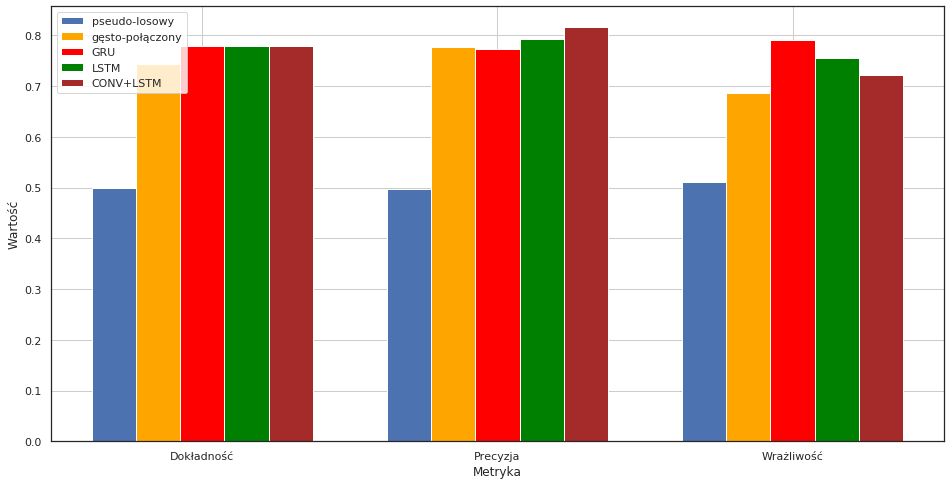

In [150]:
def plot():
    fig = plt.figure(figsize=(16, 8))
    color = ['b', 'orange', 'red', 'green', 'brown']
    for i, r in enumerate([r1, r2, r3, r4, r5]):
        plt.bar(r, df.iloc[1:, i], color=color[i], width=0.15)
    plt.xlabel('Metryka')
    plt.ylabel('Wartość')
    plt.xticks([r + 0.3 for r in range(3)], ['Dokładność', 'Precyzja', 'Wrażliwość'])
    plt.legend(models)
    plt.grid(1)
plot()
# df = df.sort_values(by='precision', ascending=False)
# fig = plt.figure(figsize=(10, 6))
# _ = plt.bar(r2, df.iloc[1:, 1], color='orange',width=0.2)
# _ = plt.xlabel('Model')
# _ = plt.ylabel('Precyzja')

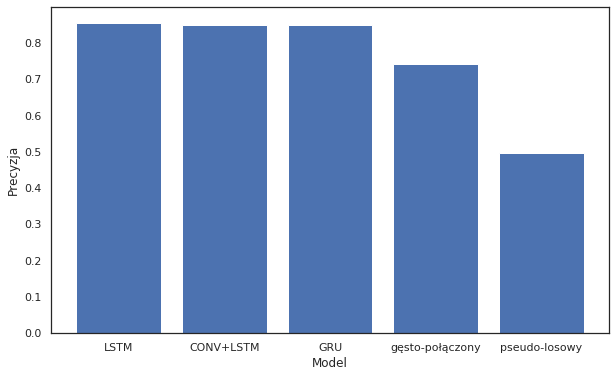

In [86]:
df = df.sort_values(by='precision', ascending=False)
# fig = plt.figure(figsize=(10, 6))
_ = plt.bar(df.index, df.precision, color='b')
_ = plt.xlabel('Model')
_ = plt.ylabel('Precyzja')

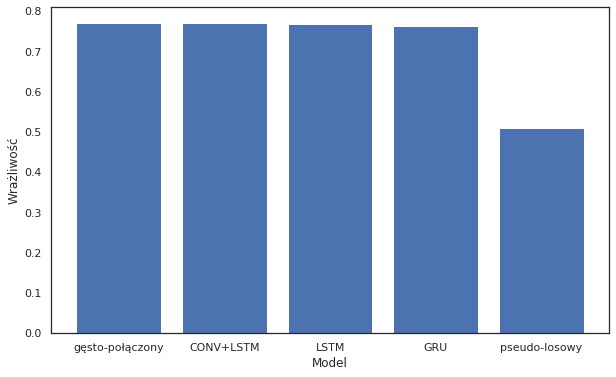

In [85]:
df = df.sort_values(by='recall', ascending=False)
fig = plt.figure(figsize=(10, 6))
_ = plt.bar(df.index, df.recall, color='b')
_ = plt.xlabel('Model')
_ = plt.ylabel('Wrażliwość')